In [1]:
import copy

import numpy as np
import numpy.linalg as LA
# import scipy.sparse.linalg as LAs
from scipy import sparse


def base_n(num, b, numerals="0123456789abcdefghijklmnopqrstuvwxyz"):
    return ((num == 0) and numerals[0]) or (base_n(num // b, b, numerals).lstrip(numerals[0]) + numerals[num % b])


def get_hamr(Ns, Nl, Zj, Zg, Zh):
    H_i = []
    H_j = []
    Hv = []

    for i in range(Nl):
        cfg = base_n(i, 2).zfill(Ns)

        # f(Zj, pos_i, pos_{i+1})
        for pos_i in range(Ns-1):
            pos_next = pos_i + 1
            H_i.append(i)
            H_j.append(i)
            Hv.append(-Zj * (int(cfg[pos_i]) * 2 - 1)
                      * (int(cfg[pos_next]) * 2 - 1))

        # f(Zh, Z)
        for pos_i in range(Ns):
            H_i.append(i)
            H_j.append(i)
            Hv.append(-Zh*(int(cfg[pos_i])*2-1))

        # f(Zg, X)
        for pos_i in range(Ns):
            _cfg = copy.copy(cfg)   # shallow copy

            if cfg[pos_i] == '0':
                _cfg = _cfg[:pos_i]+'1'+_cfg[pos_i+1:]
            else:
                _cfg = _cfg[:pos_i]+'0'+_cfg[pos_i+1:]

            j1 = int(_cfg, 2)
            H_i.append(j1)
            H_j.append(i)
            Hv.append(-Zg)

    Hamr = sparse.coo_matrix((Hv, (H_i, H_j)), shape=(Nl, Nl)).tocsc()
    # print(Hamr)

    return Hamr


def get_psi0(Ns, Nl, mode, Pos=0):
    if mode == 'rand':
        psi = np.random.rand(Nl, 1) + 1j*np.random.rand(Nl, 1) - 0.5
    elif mode == 'site':
        psi = np.zeros((Nl, 1)) + 1j*np.zeros((Nl, 1))

        cfg = base_n(0, 2).zfill(Ns)
        _cfg = cfg[:Pos] + '1' + cfg[Pos+1:]
        j1 = int(_cfg, 2)
        psi[j1] = 1.0
    else:
        raise ValueError('Unsupported mode')

    psi /= LA.norm(psi)  # default paras

    return psi


def get_coeff(Nl, psi, V):

    coeff = np.zeros((Nl), dtype=np.complex)

    for i in range(Nl):
        coeff[i] = np.dot(np.transpose(np.conj(V[:, i])), psi)

    return coeff


def Evo(Nl, S, V, coeff, t):
    psi = np.zeros((Nl, 1), dtype=np.complex)

    for i in range(Nl):
        psi += coeff[i] * V[:, i] * np.exp(-1j * S[i] * t)

    return psi


def calX(Ns, Nl, psi):

    MagX = np.zeros(Ns)

    for Pos in range(Ns):
        PsiX = np.zeros(Nl) + 1j*np.zeros(Nl)
        for i in range(Nl):
            cfg = base_n(i, 2).zfill(Ns)
            if cfg[Pos] == '0':
                _cfg = cfg[:Pos]+'1'+cfg[Pos+1:]
            else:
                _cfg = cfg[:Pos]+'0'+cfg[Pos+1:]
            j1 = int(_cfg, 2)
            PsiX[j1] = psi[i, 0]
        MagX[Pos] = np.real(np.sum(np.conj(psi[:, 0]) * PsiX))

    return MagX


def calZ(Ns, Nl, psi):

    MagZ = np.zeros(Ns)

    for Pos in range(Ns):
        PsiZ = np.zeros(Nl) + 1j*np.zeros(Nl)
        for i in range(Nl):
            cfg = base_n(i, 2).zfill(Ns)
            PsiZ[i] = (int(cfg[Pos]) * 2 - 1) * psi[i, 0]
        MagZ[Pos] = np.real(np.sum(np.conj(psi[:, 0]) * PsiZ))

    return MagZ


def get_mag(t, Ns, Zg, Zh, Np=2, Zj=1.0):

    Nl = Np**Ns

    Hamr = get_hamr(Ns, Nl, Zj, Zg, Zh)

    S, V = LA.eigh(Hamr.todense())

    psi0 = get_psi0(Ns, Nl, 'rand')
    # psi0 = get_psi0(Ns, Nl, 'site', 1)

    coeff = get_coeff(Nl, psi0, V)

    psi = Evo(Nl, S, V, coeff, t)

    MagX = calX(Ns, Nl, psi)
    MagZ = calZ(Ns, Nl, psi)

    return MagX, MagZ


def get_mag_seq(time, step, Ns, Zg, Zh, Np=2, Zj=1.0):

    Nl = Np**Ns

    Hamr = get_hamr(Ns, Nl, Zj, Zg, Zh)

    S, V = LA.eigh(Hamr.todense())

    psi0 = get_psi0(Ns, Nl, 'rand')

    coeff = get_coeff(Nl, psi0, V)

    mag_x = []
    mag_z = []

    for t in np.arange(0, time, step):

        psi = Evo(Nl, S, V, coeff, t)

        mag_x.append(calX(Ns, Nl, psi))
        mag_z.append(calZ(Ns, Nl, psi))

    return np.array(mag_x), np.array(mag_z)


def get_psi_seq(time, step, Ns, Zg, Zh, Np=2, Zj=1.0):

    Nl = Np**Ns

    Hamr = get_hamr(Ns, Nl, Zj, Zg, Zh)

    S, V = LA.eigh(Hamr.todense())

    psi0 = get_psi0(Ns, Nl, 'rand')

    coeff = get_coeff(Nl, psi0, V)

    _seq = []

    for t in np.arange(0, time, step):

        _psi = Evo(Nl, S, V, coeff, t)
        _seq.append(_psi.reshape(Nl))

    return np.array(_seq)


if __name__ == "__main__":

    Ns = 3

    Zg = -1.05  # 0.5
    Zh = 0.5    # 0.4

    # x, z = get_mag(30, Ns, Zg, Zh)
    x = get_psi_seq(1.0, 0.1, Ns, Zg, Zh)
    print(x)


[[ 0.09692569+0.21204996j  0.20865813+0.02652354j  0.17862362+0.48854898j
   0.27434524+0.14333602j  0.13943901+0.18523083j  0.06047077+0.33274136j
   0.00164276+0.37131169j  0.08547915+0.47084234j]
 [ 0.15041050+0.14459865j  0.27185115-0.04466508j  0.35562144+0.36880124j
   0.36122792+0.10058709j  0.23490061+0.14499257j  0.17064489+0.26497622j
   0.09562113+0.32067003j  0.00608505+0.43582411j]
 [ 0.17758132+0.0493882j   0.30891889-0.14040148j  0.47526298+0.19084928j
   0.41921350+0.04876668j  0.30473612+0.07764432j  0.24783035+0.17723224j
   0.16429069+0.25798363j -0.07058332+0.34671724j]
 [ 0.17057838-0.06212588j  0.31448393-0.24821862j  0.52238794-0.01866613j
   0.43685768-0.0049429j   0.34312545-0.00473044j  0.28064492+0.08044695j
   0.19606279+0.19058159j -0.13088448+0.21803822j]
 [ 0.12689345-0.17691403j  0.28711029-0.35316523j  0.49201328-0.22819947j
   0.40882471-0.05361595j  0.34818914-0.08752412j  0.26421139-0.01369846j
   0.18541084+0.12557458j -0.16484305+0.07117763j]
 [ 0.

In [2]:
"""
Created on 7/7/18

@author: chefcasey (chefcasey@pm.me)
@coauthor:

@description:
"""

import os

import numpy as np

from ED import get_psi_seq

Ns = 5

Zg = -1.05  # 0.5
Zh = 0.5    # 0.4

time = 30
step = 0.1

n_trial = 1000


dirname = 'N=' + str(Ns)
dirpathname = os.path.join('./data/', dirname)

if not os.path.exists(dirpathname):
    os.mkdir(dirpathname)

print(dirpathname)

filename = 'g=' + str(Zg) + '_h=' + str(Zh) + \
    '_step=' + str(step) + '_rand.npy'

print(filename)

pathname = os.path.join(dirpathname, filename)


data = []

for i in range(n_trial):

    _seq = get_psi_seq(time, step, Ns, Zg, Zh)
    data.append(_seq)

seqs = np.array(data)

np.save(pathname, seqs)

print(seqs.shape)


./data/N=5
g=-1.05_h=0.5_step=0.1_rand.npy
(1000, 300, 32)


In [5]:
"""
Created on 7/13/18

@author: chefcasey (chefcasey@pm.me)
@coauthor:

@description:
"""

import os

import numpy as np
import matplotlib.pyplot as plt

global Ns, step,learning_rate,n_epoch,n_trial,time
global dpath,rpath,file,checkpoint_epoch

Ns = 5

#data
n_trial = 100
time = 30
step = 0.05

#model
n_epoch = 5
learning_rate = 0.25
checkpoint_epoch = 30

#path
dpath = './data/N='+str(Ns)+'/'
rpath = './results/N='+str(Ns)+'/n_trial='+str(n_trial)+'_time='+str(time)+'_step='+str(step)+\
        '/n_epoch='+str(n_epoch)+'_learning_rate='+str(learning_rate)+'/'
file = 'n_trial='+str(n_trial)+'_time='+str(time)+'_step=' + str(step) + '_rand.npy'



def set_Ns():
    a = Ns
    return a

def set_n_trial():
    a = n_trial
    return a

def set_time():
    a = time
    return a

def set_step():
    a = step
    return a

def set_n_epoch():
    a = n_epoch
    return a

def set_learning_rate():
    a = learning_rate
    return a

def set_checkpoint_epoch():
    a = checkpoint_epoch
    return a

def set_dpath():
    a = dpath
    return a

def set_rpath():
    a = rpath
    return a

def set_file():
    a = file
    return a



if not os.path.exists(dpath):
    os.mkdir(dpath)
    
if not os.path.exists(rpath):
    os.makedirs(rpath)

#creat and save result pictures
def vis(pred, targ, sidx, figname):
    if pred.dtype == np.complex:
        _tr = targ[:, sidx].real
        _ti = targ[:, sidx].imag
        _pr = pred[:, sidx].real
        _pi = pred[:, sidx].imag
    else:
        _tr = targ[:, sidx, 0]
        _ti = targ[:, sidx, 1]
        _pr = pred[:, sidx, 0]
        _pi = pred[:, sidx, 1]

    plt.figure(figsize=(10, 5))

    _tx = np.arange(targ.shape[0])
    _px = np.arange(pred.shape[0])

    plt.subplot(211)
    plt.title('State for Time Sequence')
    plt.plot(_tx, _tr, 'g', label='Target', alpha=0.5)
    plt.plot(_px, _pr, label='Model Op')
    plt.ylabel('Real')
    plt.legend()

    plt.subplot(212)
    plt.plot(_tx, _ti, 'g', label='Target', alpha=0.5)
    plt.plot(_px, _pi, label='Model Op')
    plt.ylabel('Imaginary')
    plt.xlabel('Time steps')
    plt.legend()

    plt.savefig(os.path.join(rpath, figname))
    plt.close()


def loader(file):
    _data = np.load(os.path.join(dpath, file))
    data = np.stack((_data.real, _data.imag), axis=3)

    assert _data[-1, 0, -1].real == data[-1, 0, -1, 0]
    assert _data[-1, 0, -1].imag == data[-1, 0, -1, 1]

    n_test = _data.shape[0] // 10
    train = data[n_test:]
    test = data[:n_test]

    return train, test


class LossMaster:

    def __init__(self):
        self.loss = []

        self.test_loss_x = []
        self.test_loss_y = []

    def push(self, loss, epoch=0, ltype=None):
        if ltype is None:
            self.loss.append(loss)
        else:
            self.test_loss_x.append(epoch)
            self.test_loss_y.append(loss)

    def draw(self):
        plt.plot(self.loss)
        plt.scatter(self.test_loss_x, self.test_loss_y)

        plt.show()


if __name__ == '__main__':
    pass








Net32(
  (bilinear): Bilinear(in1_features=32, in2_features=32, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (linear1): Linear(in_features=128, out_features=32, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
)
=== Epoch 1-10 ===
=== Epoch 11-20 ===


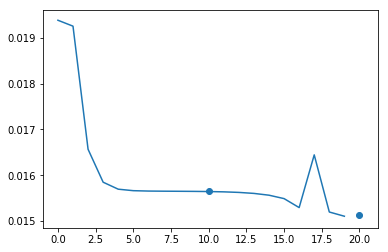

In [6]:
"""
Created on 7/7/18

@author: chefcasey (chefcasey@pm.me)
@coauthor:

@description:
"""

import torch
import torch.nn as nn
from torch.optim import LBFGS

from utils import *

np.random.seed(0)
torch.manual_seed(0)

n_epoch = 2
n_iter = 10
learning_rate = 0.5

future = 100
testi = 0

_train, _test = loader()#建立数据集
input_train = torch.from_numpy(_train[:, :-1, :, :])
output_train = torch.from_numpy(_train[:, 1:, :, :])
input_test = torch.from_numpy(_test[:, :-1, :, :])
output_test = torch.from_numpy(_test[:, 1:, :, :])


class Net32(nn.Module):

    def __init__(self):
        super(Net32, self).__init__()

        self.bilinear = nn.Bilinear(32, 32, 128)
        self.lstm = nn.LSTMCell(128, 128)
        self.linear1 = nn.Linear(128, 32)
        self.linear2 = nn.Linear(128, 32)
#前向传播：
    def forward(self, x, n_fp=0): 
        # print(x.shape)

        h_t = torch.zeros(x.size(0), 128, dtype=torch.double)
        c_t = torch.zeros(x.size(0), 128, dtype=torch.double)

        out = []

        for t, in_t in enumerate(x.chunk(x.size(1), dim=1)):
            in_t.squeeze_()  #去除size为1的维度
            # print(in_t.shape)

            _out = self.bilinear(in_t[:, :, 0], in_t[:, :, 1])
            h_t, c_t = self.lstm(_out, (h_t, c_t))
            _out1 = self.linear1(h_t)
            _out2 = self.linear2(h_t)

            _out = torch.stack((_out1, _out2), dim=2)
            # print(_out.shape)

            out.append(_out)

        # Predict the future
        for idx in range(n_fp):
            _out = self.bilinear(_out1, _out2)
            h_t, c_t = self.lstm(_out, (h_t, c_t))
            _out1 = self.linear1(h_t)
            _out2 = self.linear2(h_t)

            _out = torch.stack((_out1, _out2), dim=2)
            out.append(_out)

        return torch.stack(out, dim=1)


net = Net32()
print(net)

net.double()
criterion = nn.MSELoss()  # TODO: Check MSELoss usage

# Use LBFGS as optimizer since we can load the whole data to train
optimizer = LBFGS(net.parameters(), lr=learning_rate, max_iter=n_iter)  # 0.8

lm = LossMaster()

for i in range(n_epoch):
    print('=== Epoch {0}-{1} ==='.format(i * n_iter + 1, i * n_iter + n_iter))

    def closure():
        optimizer.zero_grad()
        out = net(x=input_train)
        _loss = criterion(out, output_train)

        # print('Train Loss: {}'.format(_loss.item()))
        lm.push(_loss.item())

        _loss.backward()
        return _loss

    optimizer.step(closure)

    with torch.no_grad():#预测
        pred = net(x=input_test, n_fp=future)
        _loss = criterion(pred[:, :-future], output_test)

        # print('Test Loss: {}'.format(_loss.item()))
        lm.push(_loss.item(), (i + 1) * n_iter, 'test')

        y = pred.detach().numpy()

    vis(y[testi], input_test.numpy()[testi], 0,
        'Result on Epoch {}.png'.format((i + 1) * n_iter))

lm.draw()


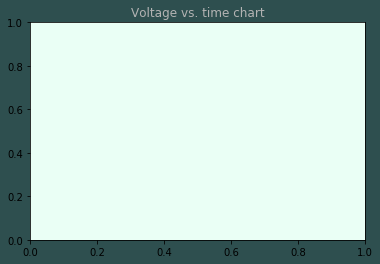

In [5]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0.0, 2.0, 201)
s = np.sin(2 * np.pi * t)
plt.show()

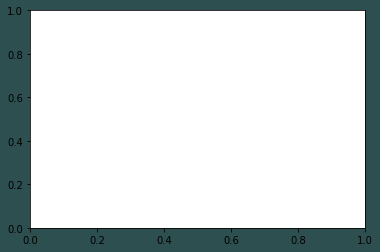

In [6]:
fig, ax = plt.subplots(facecolor=(.18, .31, .31))
plt.show()

In [7]:
ax.set_facecolor('#eafff5')
plt.show()

In [9]:
ax.set_title('Voltage vs. time chart', color='0.7')
plt.show()